# Course Reviews Sentiment Analysis

This notebook performs sentiment analysis on course reviews using:
1. VADER (Rule-based sentiment analysis)
2. Transformer-based analysis (using DistilBERT)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')  
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bhuva\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bhuva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_csv('data/user_courses_review_test_set.csv')
df.head()

,course_name,lecture_name,review_rating,review_comment
0,Advanced Microsoft Excel,F1 to F12 - Using Excel's Function Keys,5,perfect
1,Agile and Scrum Project Management,Agile vs Waterfall - Conclusions,1,The SCRUM chapter are full of errors
2,AI Applications for Business Success,Correlation vs. Causation,3,Bad quality of audio and narrative
3,AI Applications for Business Success,Correlation vs. Causation,3,I need documentation about lecture.
4,Building a 3-Statement Model in Excel,Calculating Cash Flows and Completing the Mode...,5,Great course! Ned has a talent for explaining ...


In [3]:
df.shape

(154, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   course_name     154 non-null    object
 1   lecture_name    154 non-null    object
 2   review_rating   154 non-null    int64 
 3   review_comment  150 non-null    object
dtypes: int64(1), object(3)
memory usage: 4.9+ KB


Rating distribution:


review_rating
1      3
2      1
3     11
4     18
5    121
Name: count, dtype: int64

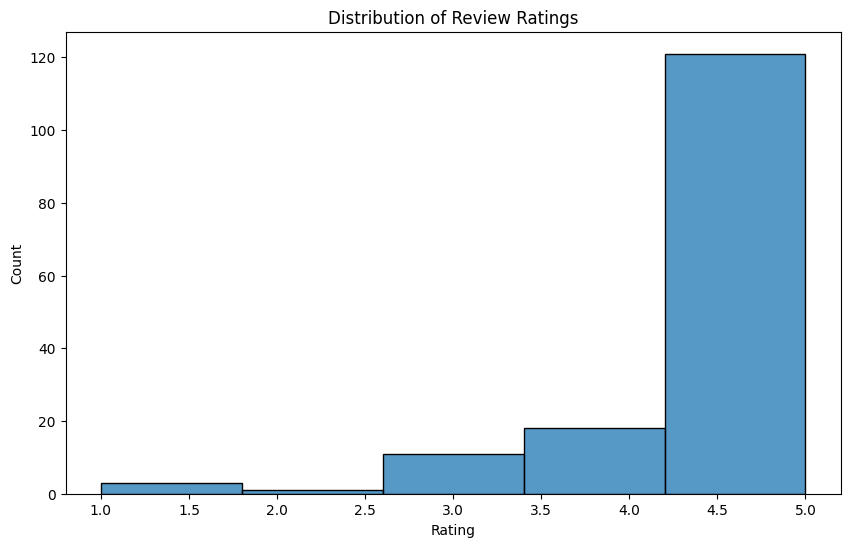

In [5]:
# Analyze ratings distribution
print("Rating distribution:")
rating_dist = df['review_rating'].value_counts().sort_index()
display(rating_dist)

# Visualize rating distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='review_rating', bins=5)
plt.title('Distribution of Review Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [6]:
# Course-wise analysis
course_ratings = df.groupby('course_name')['review_rating'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print("\nCourse-wise ratings:")
display(course_ratings)


Course-wise ratings:


,mean,count
course_name,,
Advanced Microsoft Excel,5.000000,1
Building a 3-Statement Model in Excel,5.000000,1
Corporate Strategy,5.000000,1
Convolutional Neural Networks with TensorFlow in Python,5.000000,2
Python for Social Media Analytics,5.000000,1
"The Complete Data Visualization Course with Python, R, Tableau, and Excel",5.000000,2
Customer Analytics in Python,5.000000,1
Data Analysis with Excel Pivot Tables,5.000000,1
How to Think Like a Data Scientist to Become One,5.000000,2


In [7]:
def preprocess_text(text):
    """Clean and preprocess text data."""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.strip()

In [8]:
# Apply preprocessing
df['processed_comment'] = df['review_comment'].apply(preprocess_text)

# Show sample of processed text
display(pd.DataFrame({
    'Original': df['review_comment'].head(),
    'Processed': df['processed_comment'].head()
}))

,Original,Processed
0,perfect,perfect
1,The SCRUM chapter are full of errors,the scrum chapter are full of errors
2,Bad quality of audio and narrative,bad quality of audio and narrative
3,I need documentation about lecture.,i need documentation about lecture
4,Great course! Ned has a talent for explaining ...,great course ned has a talent for explaining t...


## Sentiment Analysis using VADER

🔄 Performing VADER sentiment analysis...


Analyzing sentiments: 100%|██████████| 154/154 [00:00<00:00, 2666.79it/s]


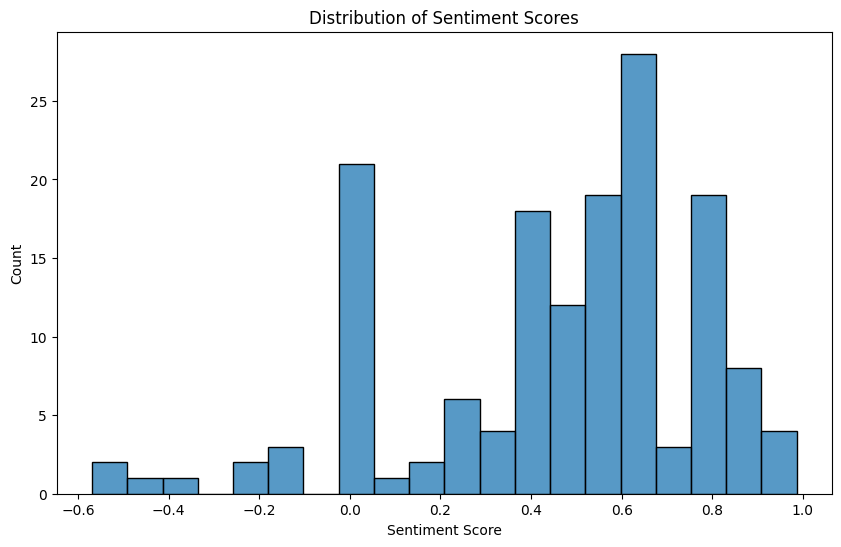

In [9]:
# Initialize VADER sentiment analyzer
print("🔄 Performing VADER sentiment analysis...")
sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    """Get sentiment scores using VADER."""
    if pd.isna(text) or text == "":
        return 0
    return sia.polarity_scores(text)['compound']

# Apply sentiment analysis with progress bar
tqdm.pandas(desc="Analyzing sentiments")
df['sentiment_score'] = df['review_comment'].progress_apply(get_sentiment_scores)

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='sentiment_score', bins=20)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

## Sentiment Analysis using Transformers

In [10]:
# Initialize transformer pipeline
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [11]:
def get_transformer_sentiment(text):
    """Get sentiment using transformer model."""
    if pd.isna(text) or text == "":
        return 'NEUTRAL'
    tokens = tokenizer(text, truncation=True, max_length=512)
    result = sentiment_pipeline(text)[0]
    return result['label']

In [12]:
# Analyze a sample of the data
sample_size = min(100, len(df))
df_sample = df.head(sample_size).copy()
tqdm.pandas(desc="Analyzing with transformer")
df_sample['transformer_sentiment'] = df_sample['review_comment'].progress_apply(get_transformer_sentiment)

Analyzing with transformer: 100%|██████████| 100/100 [00:05<00:00, 18.69it/s]


In [13]:
display(df_sample['transformer_sentiment'].value_counts())

transformer_sentiment
POSITIVE    87
NEGATIVE     9
NEUTRAL      4
Name: count, dtype: int64

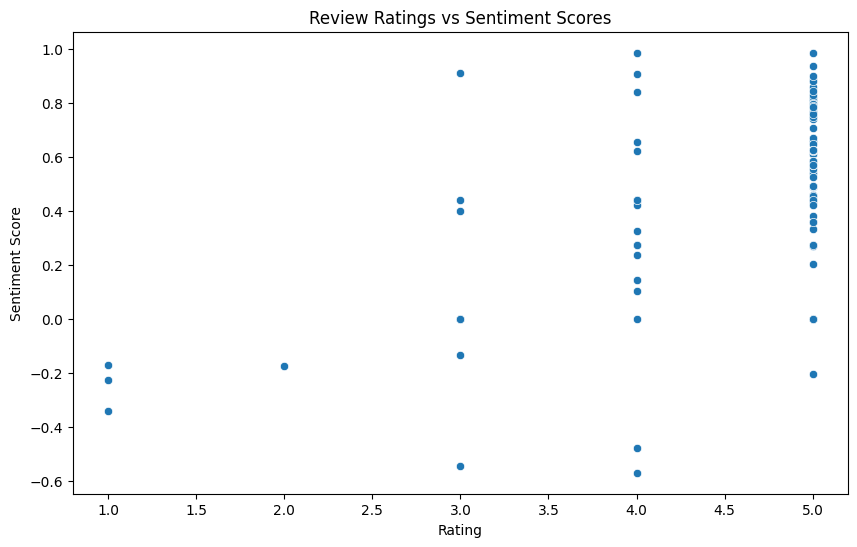

In [14]:
# Calculate correlation
correlation = df['review_rating'].corr(df['sentiment_score'])

# Visualize relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='review_rating', y='sentiment_score')
plt.title('Review Ratings vs Sentiment Scores')
plt.xlabel('Rating')
plt.ylabel('Sentiment Score')
plt.show()


## Insights

In [15]:
# Print insights
print("Key Insights:")
print("1. Rating Distribution:", 
      f"\n   - Average rating: {df['review_rating'].mean():.2f}",
      f"\n   - Most common rating: {df['review_rating'].mode()[0]}")

print("\n2. Sentiment Analysis:",
      f"\n   - Average sentiment score: {df['sentiment_score'].mean():.2f}",
      f"\n   - Correlation with ratings: {correlation:.2f}")

print("\n3. Course Performance:",
      f"\n   - Best rated course: {course_ratings.index[0]}",
      f"\n   - Most reviewed course: {course_ratings.sort_values('count', ascending=False).index[0]}")

Key Insights:
1. Rating Distribution: 
   - Average rating: 4.64 
   - Most common rating: 5

2. Sentiment Analysis: 
   - Average sentiment score: 0.46 
   - Correlation with ratings: 0.51

3. Course Performance: 
   - Best rated course: Advanced Microsoft Excel 
   - Most reviewed course: Introduction to Data and Data Science
